# Ising Model (incl. Monte Carlo)

## Simulation initialisation & results

In [41]:
# Needs to be called before importing matplotlib
#%matplotlib inline
%matplotlib notebook
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from types import SimpleNamespace

# Simulation initialisation
sim = SimpleNamespace(time_steps = 100,
                      L = 30,
                      T = 3,
                      dT = 0,
                      h = 0,
                      dh = 0,
                      J = 1,
                      kb = 1,
                      spin_init = 'up')
sim.spin_site_total_number = sim.L**2
sim.MCS = sim.L**2
                      
grid_x, grid_y = [range(sim.L), range(sim.L)]
grid_coordinates_x, grid_coordinates_y = np.meshgrid(grid_x, grid_y) 
grid_coordinates_x, grid_coordinates_y = [np.reshape(grid_coordinates_x,(1,-1)), np.reshape(grid_coordinates_y,(1,-1))]
spin_site_numbers = range(sim.spin_site_total_number)

grid_spins = assign_spin(sim)

energy_i = system_energy(grid_coordinates_x, grid_coordinates_y, grid_spins, spin_site_numbers)
magnitization_total = np.zeros([sim.time_steps + 1, 1])
T_total = np.zeros([sim.time_steps, 1])
h_total = np.zeros([sim.time_steps, 1])

energy_total = np.zeros([sim.time_steps + 1, 1])
energy_total[0] = energy_i

magnitization_i = magnetisation(grid_spins, sim.spin_site_total_number)
magnitization_total[0] = magnitization_i

for i, t in enumerate(range(sim.time_steps)):
    grid_spins, energy_i = spin_flip(sim, grid_coordinates_x, grid_coordinates_y, grid_spins, energy_i)
    energy_total[i + 1] = energy_i    
    magnitization_total[i + 1] = magnetisation(grid_spins, sim.spin_site_total_number)
      
    T_total[i] = sim.T 
    h_total[i] = sim.h
        
    sim.T += sim.dT
    sim.h += sim.dh
    

## Plotting

<IPython.core.display.Javascript object>


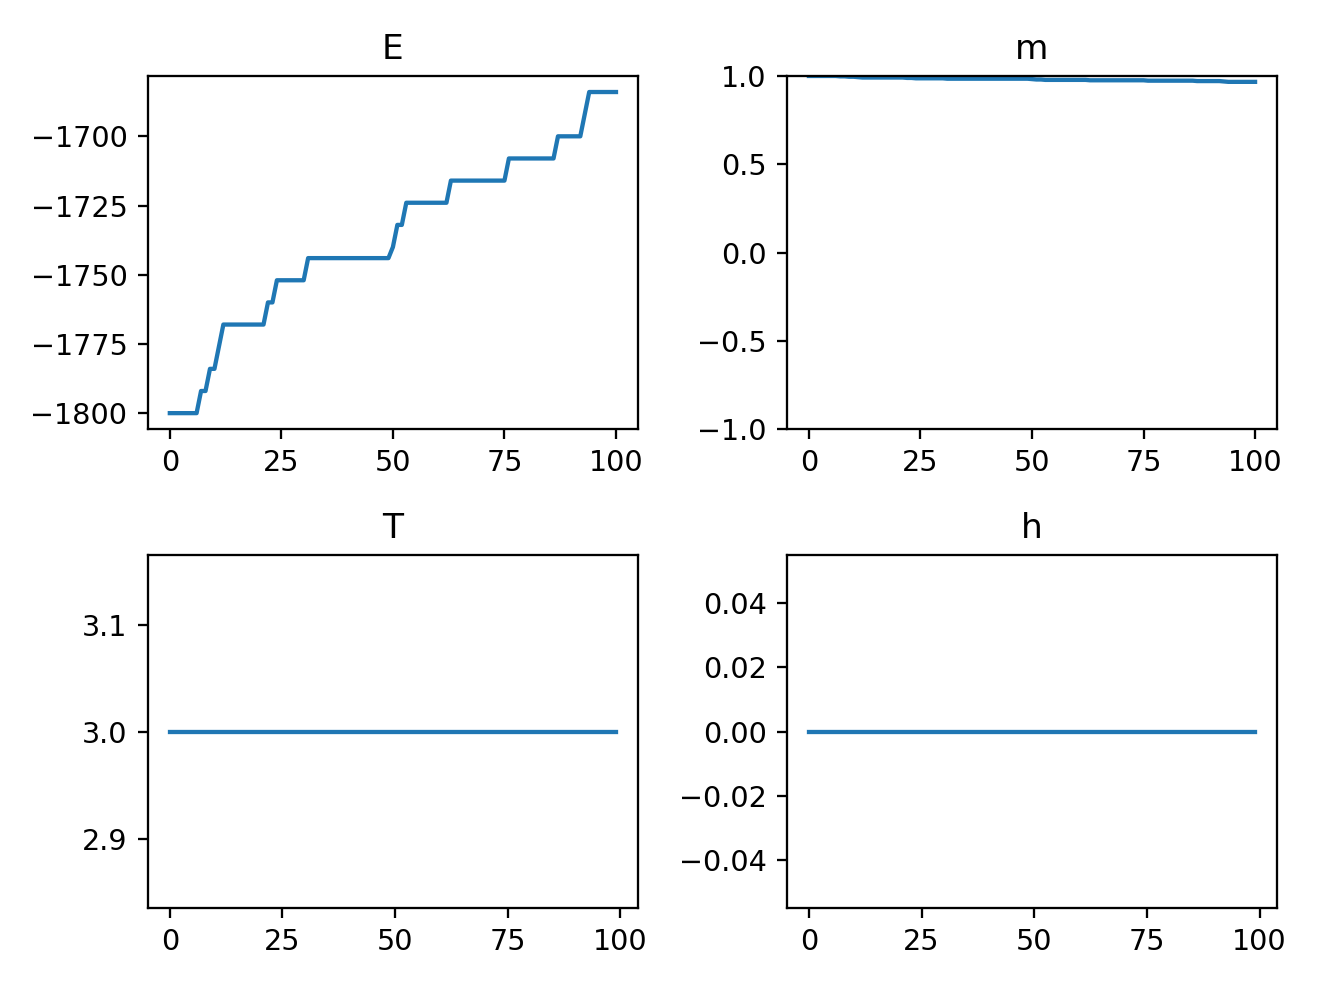

In [12]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.plot(range(sim.time_steps+1), energy_total, '-')
plt.title('E')

ax2 = fig.add_subplot(222)
ax2.plot(range(sim.time_steps+1), magnitization_total, '-')
plt.ylim([-1,1])
plt.title('m')

ax3 = fig.add_subplot(223)
ax3.plot(range(sim.time_steps), T_total, '-')
plt.title('T')

ax4 = fig.add_subplot(224)
ax4.plot(range(sim.time_steps), h_total, '-')
plt.title('h')


plt.tight_layout()
fig = plt.gcf()

plt.show()



## Function definitions

In [2]:
def grid_plot(x, y, S):
    image = plt.imshow(S, extent=(x.min(), x.max(), y.max(), y.min()), interpolation='nearest', cmap=cm.plasma)
    plt.clim(-1,1)
    plt.xlabel('y')
    plt.ylabel('x')
    return image

def assign_spin(sim):
    if sim.spin_init == 'random':
        grid_spins = rnd.rand(sim.L, sim.L)
        grid_spins[grid_spins >= 0.5] = 1
        grid_spins[grid_spins <  0.5] = -1
        
    elif sim.spin_init == 'up':
        grid_spins = np.ones([sim.L,sim.L], dtype= int)
        
    elif sim.spin_init == 'down':
        grid_spins = -1*np.ones([sim.L,sim.L], dtype= int)
        
    return grid_spins

def spin_site_energy(sim, spin_site_x, spin_site_y, grid_spins):
    spin_site_energy = 0
    
    spin_neigbour_x = (spin_site_x + np.array([1, -1, 0, 0]))%(sim.L)
    spin_neigbour_y = (spin_site_y + np.array([0, 0, 1, -1]))%(sim.L)
    
    for i in range(np.size(spin_neigbour_x)):
        spin_value_center = grid_spins[spin_site_x, spin_site_y]
        spin_value_neighbour = grid_spins[spin_neigbour_x[i], spin_neigbour_y[i]]

        spin_site_energy += -sim.J*spin_value_center*spin_value_neighbour - sim.h*spin_value_center
        
    return spin_site_energy 

def system_energy(grid_coordinates_x, grid_coordinates_y, grid_spins, spin_site_numbers):
    sys_energy = 0
    for spin_site_number in spin_site_numbers:
        spin_site_x = grid_coordinates_x[0][spin_site_number]
        spin_site_y = grid_coordinates_y[0][spin_site_number]
        sys_energy += spin_site_energy(sim, spin_site_x, spin_site_y, grid_spins)
    sys_energy = sys_energy/2 # To counter double counting of the links
    return sys_energy


def spin_flip(sim, grid_coordinates_x, grid_coordinates_y, grid_spins, E_system):
    spin_site_number = rnd.randint(0, sim.spin_site_total_number)
    spin_site_x = grid_coordinates_x[0][spin_site_number]
    spin_site_y = grid_coordinates_y[0][spin_site_number]
       
    spin_site_energy_pre_flip = spin_site_energy(sim, spin_site_x, spin_site_y, grid_spins)
    grid_spins[spin_site_x, spin_site_y] = -1 * grid_spins[spin_site_x, spin_site_y]
    spin_site_energy_post_flip = spin_site_energy(sim, spin_site_x, spin_site_y, grid_spins) 
    
    spin_flip_energy_delta = spin_site_energy_post_flip - spin_site_energy_pre_flip
        
    if spin_flip_energy_delta <= 0:
        E_system += spin_flip_energy_delta
        
    elif spin_flip_energy_delta > 0:
        boltzman_chance = np.exp(-spin_flip_energy_delta/(sim.kb*sim.T))
        boltzmon_pick = rnd.random()
        
        if  boltzman_chance > boltzmon_pick:
            E_system += spin_flip_energy_delta
            
        elif boltzman_chance <= boltzmon_pick:  
            grid_spins[spin_site_x, spin_site_y] = -1 * grid_spins[spin_site_x, spin_site_y]
    return grid_spins, E_system


def magnetisation(grid_spins, spin_site_total_number):
    magnetisation = np.sum(np.sum(grid_spins,axis=0))/spin_site_total_number
    return magnetisation


def acceptance_prob(sim):
    beta = 1/(sim.kb*sim.T)
    ap = np.exp(-2*beta*sim.J*np.array([4, 2, 0, -2, -4])) # 4 equal, 3 equal, 2 equal, 1 equal, 0 equal
    return ap

## Animation function

<IPython.core.display.Javascript object>


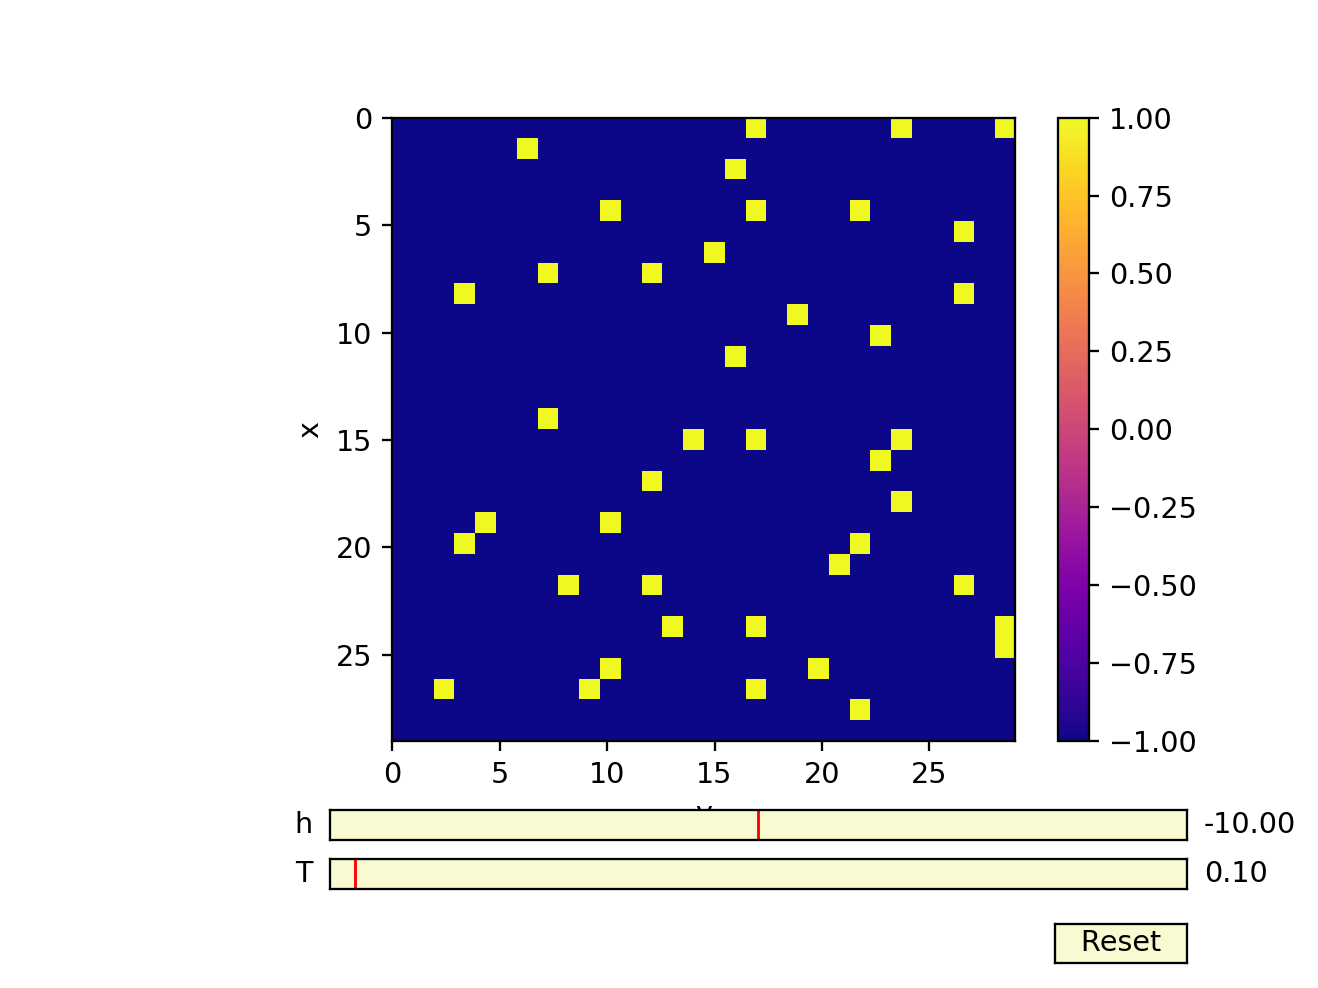

In [42]:
# Needs to be called before matplotlib is imported
%matplotlib notebook 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button, RadioButtons


fig2 = plt.figure()

im = plt.imshow(grid_spins, extent=(grid_coordinates_x.min(), grid_coordinates_x.max(), 
                                    grid_coordinates_y.max(), grid_coordinates_y.min()), 
                interpolation='nearest', cmap=cm.plasma, animated=True)
plt.clim(-1, 1)
plt.xlabel('y')
plt.ylabel('x')
plt.colorbar()
axis_color = 'lightgoldenrodyellow'

ax = fig2.add_subplot(111)

# Adjust the subplots region to leave some space for the sliders and buttons
fig2.subplots_adjust(left=0.25, bottom=0.25)

# Add two sliders for tweaking the parameters

# Define an axes area and draw a slider in it
m_slider_ax  = fig2.add_axes([0.25, 0.15, 0.65, 0.03], facecolor=axis_color)
m_slider = Slider(m_slider_ax, 'h', -10.0, 10.0, valinit=sim.h)

# Draw another slider
T_slider_ax = fig2.add_axes([0.25, 0.1, 0.65, 0.03], facecolor=axis_color)
T_slider = Slider(T_slider_ax, 'T', 0.1, 100.0, valinit=sim.T)

# Define an action for modifying the line when any slider's value changes
def sliders_on_changed(val):
    global sim
    sim.h = m_slider.val
    sim.T = T_slider.val

m_slider.on_changed(sliders_on_changed)
T_slider.on_changed(sliders_on_changed)

# Add a button for resetting the parameters
reset_button_ax = fig2.add_axes([0.8, 0.025, 0.1, 0.04])
reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')

def reset_button_on_clicked(mouse_event):
    T_slider.reset()
    m_slider.reset()

reset_button.on_clicked(reset_button_on_clicked)

def updatefig(*args):
    global sim, grid_coordinates_x, grid_coordinates_y, grid_spins, energy_i
    grid_spins, energy_i = spin_flip(sim, grid_coordinates_x, grid_coordinates_y, grid_spins, energy_i)
    im.set_array(grid_spins)
    return im,

ani = animation.FuncAnimation(fig2, updatefig, interval=10, blit=True)



6.5144230769230731